In [1]:
'''Trains LSGAN on MNIST using Keras
LSGAN is similar to DCGAN except for the MSE loss used by the 
Discriminator and Adversarial networks.
  
[1] Radford, Alec, Luke Metz, and Soumith Chintala.
"Unsupervised representation learning with deep convolutional
generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).
[2] Mao, Xudong, et al. "Least squares generative adversarial networks." 
2017 IEEE International Conference on Computer Vision (ICCV). IEEE, 2017.
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Input
from keras.optimizers import RMSprop
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

import numpy as np
import argparse

import sys
sys.path.append("..")
from lib import gan

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

In [3]:
model_name = "lsgan_mnist-practice"
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
input_shape = (image_size, image_size, 1)
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 40000

In [4]:
# build discriminator model
inputs = Input(shape=input_shape, name='discriminator_input')
discriminator = gan.discriminator(inputs, activation=None)
# [1] uses Adam, but discriminator converges easily with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)

# LSGAN uses MSE loss [2]
discriminator.compile(loss='mse',
                      optimizer=optimizer,
                      metrics=['accuracy'])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa (None, 28, 28, 1)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
__________

In [5]:
# build generator model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
generator = gan.generator(inputs, image_size)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
__________

In [7]:
# build adversarial model = generator + discriminator
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    
# freeze the weights of discriminator during adversarial training
discriminator.trainable = False
adversarial = Model(inputs,
                    discriminator(generator(inputs)),
                    name=model_name)

# LSGAN uses MSE loss [2]
adversarial.compile(loss='mse',
                    optimizer=optimizer,
                    metrics=['accuracy'])
adversarial.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         (None, 100)               0         
_________________________________________________________________
generator (Model)            (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator (Model)        (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [8]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, model_name)
gan.train(models, x_train, params)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [discriminator loss: 0.489957, acc: 0.500000] [adversarial loss: 0.317937, acc: 0.000000]
1: [discriminator loss: 0.436217, acc: 0.125000] [adversarial loss: 1.076837, acc: 0.000000]
2: [discriminator loss: 0.318647, acc: 0.500000] [adversarial loss: 0.678014, acc: 0.000000]
3: [discriminator loss: 0.195169, acc: 0.695312] [adversarial loss: 0.821097, acc: 0.000000]
4: [discriminator loss: 0.096749, acc: 0.875000] [adversarial loss: 0.358316, acc: 0.000000]
5: [discriminator loss: 0.111108, acc: 1.000000] [adversarial loss: 1.343064, acc: 0.000000]
6: [discriminator loss: 0.135078, acc: 0.851562] [adversarial loss: 0.516648, acc: 0.000000]
7: [discriminator loss: 0.137410, acc: 0.773438] [adversarial loss: 1.134449, acc: 0.000000]
8: [discriminator loss: 0.125607, acc: 0.882812] [adversarial loss: 0.535258, acc: 0.000000]
9: [discriminator loss: 0.039848, acc: 0.953125] [adversarial loss: 0.268256, acc: 0.312500]
10: [discriminator loss: 0.017624, acc: 1.000000] [adversarial loss: 0

90: [discriminator loss: 0.091125, acc: 0.968750] [adversarial loss: 0.879844, acc: 0.000000]
91: [discriminator loss: 0.214578, acc: 0.640625] [adversarial loss: 0.884336, acc: 0.000000]
92: [discriminator loss: 0.180697, acc: 0.835938] [adversarial loss: 0.888554, acc: 0.000000]
93: [discriminator loss: 0.058803, acc: 0.992188] [adversarial loss: 0.770708, acc: 0.000000]
94: [discriminator loss: 0.176875, acc: 0.562500] [adversarial loss: 1.095531, acc: 0.000000]
95: [discriminator loss: 0.230976, acc: 0.632812] [adversarial loss: 0.635315, acc: 0.000000]
96: [discriminator loss: 0.307816, acc: 0.437500] [adversarial loss: 0.957311, acc: 0.000000]
97: [discriminator loss: 0.205905, acc: 0.562500] [adversarial loss: 0.580236, acc: 0.000000]
98: [discriminator loss: 0.118245, acc: 0.968750] [adversarial loss: 0.758137, acc: 0.000000]
99: [discriminator loss: 0.069871, acc: 0.968750] [adversarial loss: 0.651935, acc: 0.000000]
100: [discriminator loss: 0.059583, acc: 1.000000] [adversar

180: [discriminator loss: 0.110716, acc: 0.859375] [adversarial loss: 0.688729, acc: 0.015625]
181: [discriminator loss: 0.132075, acc: 0.804688] [adversarial loss: 0.254264, acc: 0.562500]
182: [discriminator loss: 0.099647, acc: 0.867188] [adversarial loss: 0.576523, acc: 0.000000]
183: [discriminator loss: 0.082081, acc: 0.953125] [adversarial loss: 0.337571, acc: 0.281250]
184: [discriminator loss: 0.065468, acc: 0.953125] [adversarial loss: 0.494785, acc: 0.031250]
185: [discriminator loss: 0.060280, acc: 0.992188] [adversarial loss: 0.305608, acc: 0.390625]
186: [discriminator loss: 0.069161, acc: 0.945312] [adversarial loss: 0.506564, acc: 0.046875]
187: [discriminator loss: 0.076425, acc: 0.953125] [adversarial loss: 0.246932, acc: 0.515625]
188: [discriminator loss: 0.090472, acc: 0.882812] [adversarial loss: 0.540150, acc: 0.031250]
189: [discriminator loss: 0.093870, acc: 0.921875] [adversarial loss: 0.178733, acc: 0.750000]
190: [discriminator loss: 0.082771, acc: 0.945312]

273: [discriminator loss: 0.150043, acc: 0.789062] [adversarial loss: 0.335010, acc: 0.234375]
274: [discriminator loss: 0.162140, acc: 0.812500] [adversarial loss: 0.335670, acc: 0.250000]
275: [discriminator loss: 0.144887, acc: 0.796875] [adversarial loss: 0.450315, acc: 0.078125]
276: [discriminator loss: 0.144121, acc: 0.835938] [adversarial loss: 0.228143, acc: 0.578125]
277: [discriminator loss: 0.138856, acc: 0.843750] [adversarial loss: 0.411463, acc: 0.140625]
278: [discriminator loss: 0.178571, acc: 0.773438] [adversarial loss: 0.152504, acc: 0.890625]
279: [discriminator loss: 0.154910, acc: 0.710938] [adversarial loss: 0.691714, acc: 0.000000]
280: [discriminator loss: 0.185720, acc: 0.671875] [adversarial loss: 0.251373, acc: 0.515625]
281: [discriminator loss: 0.162478, acc: 0.757812] [adversarial loss: 0.589974, acc: 0.015625]
282: [discriminator loss: 0.176416, acc: 0.703125] [adversarial loss: 0.171542, acc: 0.796875]
283: [discriminator loss: 0.148451, acc: 0.820312]

366: [discriminator loss: 0.148912, acc: 0.812500] [adversarial loss: 0.680573, acc: 0.000000]
367: [discriminator loss: 0.156713, acc: 0.734375] [adversarial loss: 0.313096, acc: 0.328125]
368: [discriminator loss: 0.150650, acc: 0.765625] [adversarial loss: 0.583028, acc: 0.000000]
369: [discriminator loss: 0.151628, acc: 0.773438] [adversarial loss: 0.258895, acc: 0.531250]
370: [discriminator loss: 0.144614, acc: 0.835938] [adversarial loss: 0.574760, acc: 0.015625]
371: [discriminator loss: 0.167095, acc: 0.710938] [adversarial loss: 0.223075, acc: 0.656250]
372: [discriminator loss: 0.177711, acc: 0.718750] [adversarial loss: 0.567494, acc: 0.000000]
373: [discriminator loss: 0.156587, acc: 0.781250] [adversarial loss: 0.242079, acc: 0.562500]
374: [discriminator loss: 0.166892, acc: 0.742188] [adversarial loss: 0.639388, acc: 0.000000]
375: [discriminator loss: 0.176891, acc: 0.742188] [adversarial loss: 0.310207, acc: 0.281250]
376: [discriminator loss: 0.157890, acc: 0.765625]

459: [discriminator loss: 0.169218, acc: 0.765625] [adversarial loss: 0.208881, acc: 0.687500]
460: [discriminator loss: 0.250318, acc: 0.578125] [adversarial loss: 1.101082, acc: 0.000000]
461: [discriminator loss: 0.303229, acc: 0.570312] [adversarial loss: 0.354985, acc: 0.218750]
462: [discriminator loss: 0.159216, acc: 0.750000] [adversarial loss: 0.494605, acc: 0.031250]
463: [discriminator loss: 0.165908, acc: 0.796875] [adversarial loss: 0.541008, acc: 0.000000]
464: [discriminator loss: 0.130128, acc: 0.851562] [adversarial loss: 0.521840, acc: 0.046875]
465: [discriminator loss: 0.167561, acc: 0.750000] [adversarial loss: 0.536136, acc: 0.031250]
466: [discriminator loss: 0.153068, acc: 0.796875] [adversarial loss: 0.445473, acc: 0.140625]
467: [discriminator loss: 0.149904, acc: 0.804688] [adversarial loss: 0.610789, acc: 0.000000]
468: [discriminator loss: 0.131496, acc: 0.835938] [adversarial loss: 0.441940, acc: 0.109375]
469: [discriminator loss: 0.122248, acc: 0.851562]

551: [discriminator loss: 0.103138, acc: 0.882812] [adversarial loss: 0.582298, acc: 0.093750]
552: [discriminator loss: 0.100001, acc: 0.906250] [adversarial loss: 0.528444, acc: 0.125000]
553: [discriminator loss: 0.128045, acc: 0.835938] [adversarial loss: 0.626238, acc: 0.062500]
554: [discriminator loss: 0.124574, acc: 0.835938] [adversarial loss: 0.457887, acc: 0.218750]
555: [discriminator loss: 0.117013, acc: 0.851562] [adversarial loss: 0.570434, acc: 0.062500]
556: [discriminator loss: 0.134413, acc: 0.820312] [adversarial loss: 0.304270, acc: 0.421875]
557: [discriminator loss: 0.142672, acc: 0.796875] [adversarial loss: 0.953573, acc: 0.000000]
558: [discriminator loss: 0.166625, acc: 0.757812] [adversarial loss: 0.258128, acc: 0.546875]
559: [discriminator loss: 0.166986, acc: 0.726562] [adversarial loss: 0.936246, acc: 0.031250]
560: [discriminator loss: 0.205468, acc: 0.664062] [adversarial loss: 0.368185, acc: 0.281250]
561: [discriminator loss: 0.149595, acc: 0.757812]

644: [discriminator loss: 0.132903, acc: 0.835938] [adversarial loss: 0.663749, acc: 0.015625]
645: [discriminator loss: 0.119773, acc: 0.851562] [adversarial loss: 0.766132, acc: 0.000000]
646: [discriminator loss: 0.144867, acc: 0.773438] [adversarial loss: 0.306160, acc: 0.437500]
647: [discriminator loss: 0.155726, acc: 0.765625] [adversarial loss: 0.883441, acc: 0.000000]
648: [discriminator loss: 0.200283, acc: 0.695312] [adversarial loss: 0.200248, acc: 0.687500]
649: [discriminator loss: 0.168304, acc: 0.734375] [adversarial loss: 0.842460, acc: 0.000000]
650: [discriminator loss: 0.145445, acc: 0.742188] [adversarial loss: 0.416798, acc: 0.171875]
651: [discriminator loss: 0.122546, acc: 0.867188] [adversarial loss: 0.733575, acc: 0.031250]
652: [discriminator loss: 0.121952, acc: 0.835938] [adversarial loss: 0.500564, acc: 0.109375]
653: [discriminator loss: 0.118986, acc: 0.859375] [adversarial loss: 0.542120, acc: 0.093750]
654: [discriminator loss: 0.105512, acc: 0.875000]

731: [discriminator loss: 0.230325, acc: 0.625000] [adversarial loss: 0.379195, acc: 0.296875]
732: [discriminator loss: 0.181355, acc: 0.687500] [adversarial loss: 0.691900, acc: 0.031250]
733: [discriminator loss: 0.149968, acc: 0.757812] [adversarial loss: 0.435244, acc: 0.328125]
734: [discriminator loss: 0.131694, acc: 0.796875] [adversarial loss: 0.668692, acc: 0.062500]
735: [discriminator loss: 0.125266, acc: 0.812500] [adversarial loss: 0.406850, acc: 0.296875]
736: [discriminator loss: 0.130861, acc: 0.820312] [adversarial loss: 0.517140, acc: 0.093750]
737: [discriminator loss: 0.127613, acc: 0.851562] [adversarial loss: 0.479283, acc: 0.171875]
738: [discriminator loss: 0.144785, acc: 0.789062] [adversarial loss: 0.502210, acc: 0.109375]
739: [discriminator loss: 0.104675, acc: 0.882812] [adversarial loss: 0.466372, acc: 0.187500]
740: [discriminator loss: 0.137390, acc: 0.820312] [adversarial loss: 0.549863, acc: 0.109375]
741: [discriminator loss: 0.148936, acc: 0.804688]

821: [discriminator loss: 0.128827, acc: 0.835938] [adversarial loss: 0.579950, acc: 0.125000]
822: [discriminator loss: 0.126563, acc: 0.851562] [adversarial loss: 0.565935, acc: 0.140625]
823: [discriminator loss: 0.122120, acc: 0.828125] [adversarial loss: 0.332845, acc: 0.421875]
824: [discriminator loss: 0.155978, acc: 0.796875] [adversarial loss: 0.855608, acc: 0.000000]
825: [discriminator loss: 0.155109, acc: 0.765625] [adversarial loss: 0.329741, acc: 0.406250]
826: [discriminator loss: 0.163525, acc: 0.750000] [adversarial loss: 0.766630, acc: 0.062500]
827: [discriminator loss: 0.167134, acc: 0.773438] [adversarial loss: 0.392284, acc: 0.328125]
828: [discriminator loss: 0.123168, acc: 0.882812] [adversarial loss: 0.651709, acc: 0.078125]
829: [discriminator loss: 0.197956, acc: 0.687500] [adversarial loss: 0.404766, acc: 0.375000]
830: [discriminator loss: 0.174077, acc: 0.718750] [adversarial loss: 0.640230, acc: 0.046875]
831: [discriminator loss: 0.156657, acc: 0.773438]

911: [discriminator loss: 0.131145, acc: 0.851562] [adversarial loss: 0.373156, acc: 0.359375]
912: [discriminator loss: 0.156905, acc: 0.789062] [adversarial loss: 0.785552, acc: 0.015625]
913: [discriminator loss: 0.157057, acc: 0.789062] [adversarial loss: 0.372135, acc: 0.250000]
914: [discriminator loss: 0.171828, acc: 0.734375] [adversarial loss: 0.675641, acc: 0.062500]
915: [discriminator loss: 0.152325, acc: 0.726562] [adversarial loss: 0.354856, acc: 0.296875]
916: [discriminator loss: 0.138931, acc: 0.812500] [adversarial loss: 0.689557, acc: 0.046875]
917: [discriminator loss: 0.162100, acc: 0.773438] [adversarial loss: 0.309478, acc: 0.453125]
918: [discriminator loss: 0.177806, acc: 0.742188] [adversarial loss: 0.795332, acc: 0.000000]
919: [discriminator loss: 0.161629, acc: 0.789062] [adversarial loss: 0.349151, acc: 0.359375]
920: [discriminator loss: 0.152076, acc: 0.773438] [adversarial loss: 0.675961, acc: 0.078125]
921: [discriminator loss: 0.151984, acc: 0.773438]

999: [discriminator loss: 0.160280, acc: 0.773438] [adversarial loss: 0.260595, acc: 0.578125]
1000: [discriminator loss: 0.187288, acc: 0.765625] [adversarial loss: 0.989555, acc: 0.015625]
1001: [discriminator loss: 0.236029, acc: 0.625000] [adversarial loss: 0.345412, acc: 0.343750]
1002: [discriminator loss: 0.170425, acc: 0.718750] [adversarial loss: 0.670683, acc: 0.093750]
1003: [discriminator loss: 0.140492, acc: 0.812500] [adversarial loss: 0.451844, acc: 0.203125]
1004: [discriminator loss: 0.141250, acc: 0.835938] [adversarial loss: 0.562031, acc: 0.109375]
1005: [discriminator loss: 0.124069, acc: 0.843750] [adversarial loss: 0.561486, acc: 0.125000]
1006: [discriminator loss: 0.131601, acc: 0.851562] [adversarial loss: 0.421418, acc: 0.250000]
1007: [discriminator loss: 0.139247, acc: 0.820312] [adversarial loss: 0.605770, acc: 0.046875]
1008: [discriminator loss: 0.135687, acc: 0.828125] [adversarial loss: 0.559236, acc: 0.125000]
1009: [discriminator loss: 0.160118, acc:

1085: [discriminator loss: 0.165162, acc: 0.726562] [adversarial loss: 0.410684, acc: 0.265625]
1086: [discriminator loss: 0.178358, acc: 0.742188] [adversarial loss: 0.582735, acc: 0.140625]
1087: [discriminator loss: 0.135655, acc: 0.804688] [adversarial loss: 0.442085, acc: 0.265625]
1088: [discriminator loss: 0.158791, acc: 0.781250] [adversarial loss: 0.628121, acc: 0.187500]
1089: [discriminator loss: 0.147404, acc: 0.804688] [adversarial loss: 0.385545, acc: 0.375000]
1090: [discriminator loss: 0.143458, acc: 0.796875] [adversarial loss: 0.579324, acc: 0.109375]
1091: [discriminator loss: 0.156256, acc: 0.773438] [adversarial loss: 0.429501, acc: 0.312500]
1092: [discriminator loss: 0.202954, acc: 0.695312] [adversarial loss: 0.568147, acc: 0.187500]
1093: [discriminator loss: 0.155899, acc: 0.820312] [adversarial loss: 0.646258, acc: 0.046875]
1094: [discriminator loss: 0.134845, acc: 0.804688] [adversarial loss: 0.438978, acc: 0.312500]
1095: [discriminator loss: 0.173655, acc

1176: [discriminator loss: 0.180675, acc: 0.726562] [adversarial loss: 0.290610, acc: 0.515625]
1177: [discriminator loss: 0.168404, acc: 0.757812] [adversarial loss: 0.781406, acc: 0.031250]
1178: [discriminator loss: 0.144443, acc: 0.773438] [adversarial loss: 0.405604, acc: 0.296875]
1179: [discriminator loss: 0.143358, acc: 0.789062] [adversarial loss: 0.747754, acc: 0.031250]
1180: [discriminator loss: 0.176177, acc: 0.742188] [adversarial loss: 0.420593, acc: 0.218750]
1181: [discriminator loss: 0.133153, acc: 0.859375] [adversarial loss: 0.652430, acc: 0.062500]
1182: [discriminator loss: 0.147632, acc: 0.773438] [adversarial loss: 0.433078, acc: 0.203125]
1183: [discriminator loss: 0.148637, acc: 0.820312] [adversarial loss: 0.679725, acc: 0.031250]
1184: [discriminator loss: 0.148856, acc: 0.820312] [adversarial loss: 0.446467, acc: 0.218750]
1185: [discriminator loss: 0.140754, acc: 0.835938] [adversarial loss: 0.619632, acc: 0.046875]
1186: [discriminator loss: 0.125652, acc

1266: [discriminator loss: 0.167664, acc: 0.773438] [adversarial loss: 0.518302, acc: 0.187500]
1267: [discriminator loss: 0.127026, acc: 0.843750] [adversarial loss: 0.590228, acc: 0.109375]
1268: [discriminator loss: 0.131195, acc: 0.828125] [adversarial loss: 0.483095, acc: 0.234375]
1269: [discriminator loss: 0.122675, acc: 0.859375] [adversarial loss: 0.597090, acc: 0.171875]
1270: [discriminator loss: 0.128335, acc: 0.828125] [adversarial loss: 0.456190, acc: 0.187500]
1271: [discriminator loss: 0.156644, acc: 0.789062] [adversarial loss: 0.484547, acc: 0.187500]
1272: [discriminator loss: 0.157467, acc: 0.781250] [adversarial loss: 0.515113, acc: 0.171875]
1273: [discriminator loss: 0.126131, acc: 0.828125] [adversarial loss: 0.532350, acc: 0.171875]
1274: [discriminator loss: 0.157236, acc: 0.765625] [adversarial loss: 0.682319, acc: 0.046875]
1275: [discriminator loss: 0.159935, acc: 0.765625] [adversarial loss: 0.355039, acc: 0.375000]
1276: [discriminator loss: 0.178473, acc

KeyboardInterrupt: 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


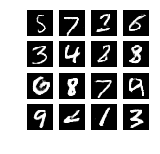

In [9]:
generator = load_model("lsgan_mnist.h5")
gan.test_generator(generator)